## Corpus specific stopwords

In addition to english stopwords available from NLTK, we can consider high IDF words also as stopwords. Same deal - low discriminative power because they occur across many documents.

We will use the wordcounts table to generate document frequencies.

In [1]:
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import re
import requests
import sqlite3
import string

from nltk.corpus import stopwords

%matplotlib inline

In [2]:
DATA_DIR = "../data"

WORDCOUNTS_DB = os.path.join(DATA_DIR, "wordcounts.db")

In [3]:
conn = sqlite3.connect(WORDCOUNTS_DB)

In [4]:
english_stopwords = set(stopwords.words('english'))


def is_number_or_fraction(word):
    return re.match(r"(\d)+(\.(\d)+)*", word) is not None


def is_all_punctuation(word):
    chars = [c for c in word if c not in string.punctuation]
    return len(chars) == 0

In [5]:
cur = conn.cursor()
cur.execute("""
SELECT word, count(doc_id) as doc_cnt
FROM (
    SELECT word, doc_id, count(*) as cnt
    FROM wordcounts
    GROUP BY word, doc_id
) GROUP BY word
ORDER BY doc_cnt DESC
LIMIT 5000
""")
candidate_stopwords = []
rows = cur.fetchall()
for row in rows:
    word = row[0]
    df = row[1]
    if len(word) < 2:
        continue
    if len(word) == 2 and word.endswith("."):
        continue
    if is_number_or_fraction(word):
        continue
    if is_all_punctuation(word):
        continue
    if word in english_stopwords:
        continue
#     print(row[0], row[1])
    candidate_stopwords.append(row)
    
cur.close()
print("{:d} candidate stopwords".format(len(candidate_stopwords)))

4448 candidate stopwords


### Decide a cutoff

We want to consider as stopwords those which occur in more than a certain fraction of the corpus. Simple measure is to consider the 90 or 95th percentile in terms of document frequency.

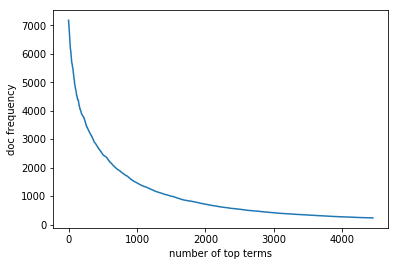

In [6]:
dfs = [row[1] for row in candidate_stopwords]
plt.plot(dfs)
plt.ylabel("doc frequency")
plt.xlabel("number of top terms")
plt.show()

In [7]:
dfs_arr = np.array(dfs)
df_cutoff = np.percentile(dfs_arr, 95)
print("DF cutoff: {:.1f}".format(df_cutoff))

DF cutoff: 3767.2


### Extract stopword file

In [8]:
fstops = open(os.path.join(DATA_DIR, "stopwords.txt"), "w")
for word, df in candidate_stopwords:
    if df > df_cutoff:
        fstops.write("{:s}\n".format(word))
fstops.close()